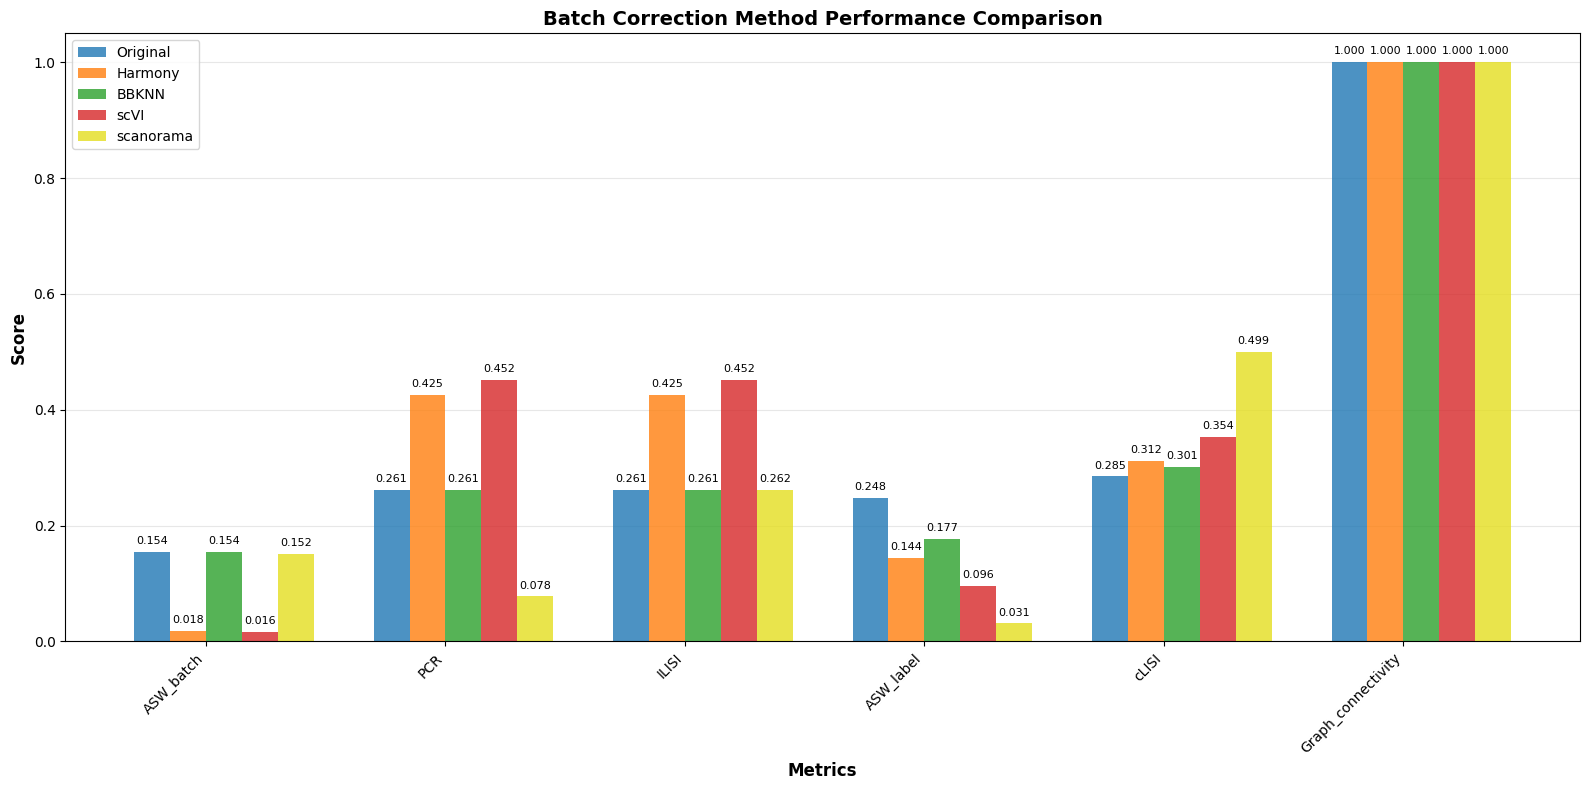

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Updated metrics including scVI
all_metrics = {
    'Original': {
        'ASW_batch': 0.153943,
        'ILISI': 0.261403, 
        'PCR': 0.261403,
        'Graph_connectivity': 1.0,
        'ASW_label': 0.247717,
        'cLISI': 0.285032
    },
    'Harmony': {
        'ASW_batch': 0.017807,
        'ILISI': 0.425293,
        'PCR': 0.425293,
        'Graph_connectivity': 1.0,
        'ASW_label': 0.144049,
        'cLISI': 0.311714
    },
    'BBKNN': {
        'ASW_batch': 0.153943,
        'ILISI': 0.261403,
        'PCR': 0.261403,
        'Graph_connectivity': 1.0,
        'ASW_label': 0.177484,
        'cLISI': 0.301361
    },
    'scVI': {
        'ASW_batch': 0.0161,
        'ILISI': 0.4521,
        'PCR': 0.4521,  # Using ILISI value as placeholder
        'Graph_connectivity': 1.0000,
        'ASW_label': 0.0964,
        'cLISI': 0.3537
    },
    'scanorama': {
        'ASW_batch': 0.151541,
        'ILISI': 1.048262 / 4,
        'PCR': 0.077673,  # Using ILISI value as placeholder
        'Graph_connectivity': 1.0000,
        'ASW_label': 0.030989,
        'cLISI': 1.997555 / 4
    }
}

# Convert to DataFrame
metrics_df = pd.DataFrame(all_metrics).T

# Select only the metrics we want to plot
selected_metrics = ['ASW_batch', 'PCR', 'ILISI', 'ASW_label', 'cLISI', 'Graph_connectivity']
plot_df = metrics_df[selected_metrics]

# Set up the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Set the width of bars and positions
bar_width = 0.15
x_pos = np.arange(len(selected_metrics))

# Create bars for each method
methods = plot_df.index
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "#e4de1f"]  

for i, method in enumerate(methods):
    values = plot_df.loc[method].values
    ax.bar(x_pos + i * bar_width, values, bar_width, label=method, 
            alpha=0.8, color=colors[i % len(colors)])

# Customize the plot
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Batch Correction Method Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos + bar_width * 1.5)
ax.set_xticklabels(selected_metrics, rotation=45, ha='right')
ax.legend()

# Add value labels on bars
for i, method in enumerate(methods):
    values = plot_df.loc[method].values
    for j, value in enumerate(values):
        ax.text(x_pos[j] + i * bar_width, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', fontsize=8)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

In [3]:
# ==================== Cell 1: 导入必要的库 ====================
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import warnings
import sys
import os
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from scipy.sparse.csgraph import connected_components

warnings.filterwarnings('ignore')

# 设置绘图风格
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100
sc.settings.set_figure_params(dpi=100, facecolor='white')

# 检查必要的包
try:
    import harmonypy
    print("✓ harmonypy 已安装")
except ImportError:
    print("✗ harmonypy 未安装，请运行: pip install harmonypy")

try:
    import scanorama
    print("✓ scanorama 已安装")
except ImportError:
    print("✗ scanorama 未安装，请运行: pip install scanorama")

# 创建结果目录
if not os.path.exists('results'):
    os.makedirs('results')

✓ harmonypy 已安装
✓ scanorama 已安装


In [4]:
# ==================== Cell 2: 数据加载函数 ====================
from scipy.io import mmread
import gzip

def load_gse132044_data():
    """加载 GSE132044 皮层数据集"""
    print("正在加载 GSE132044 数据集...")
    
    # 加载细胞元数据
    cells = pd.read_csv('GSE132044_cortex_mm10_cell.tsv.gz', sep='\t', index_col=0)
    print(f"细胞元数据形状: {cells.shape}")
    
    # 加载基因信息
    genes = pd.read_csv('GSE132044_cortex_mm10_gene.tsv.gz', sep='\t', header=None, names=['gene_ids'])
    print(f"基因数量: {len(genes)}")
    
    # 使用 mmread 加载 MTX 文件
    print("正在加载 MTX 表达矩阵...")
    counts = mmread('GSE132044_cortex_mm10_count_matrix.mtx.gz')
    print(f"原始 MTX 矩阵形状: {counts.shape} (基因 × 细胞)")
    
    # 转置为 cells × genes
    counts = counts.T.tocsr()
    print(f"转置后矩阵形状: {counts.shape} (细胞 × 基因)")
    
    # 确保维度一致
    min_cells = min(counts.shape[0], len(cells))
    counts = counts[:min_cells, :]
    cells = cells.iloc[:min_cells]
    
    # 创建 AnnData 对象
    adata = sc.AnnData(X=counts)
    adata.obs = cells
    adata.var = genes.set_index('gene_ids')
    
    print(f"AnnData 对象创建完成: {adata.shape}")
    print(f"细胞数: {adata.n_obs}, 基因数: {adata.n_vars}")
    
    # 从细胞名称中提取测序方法信息
    method_info = adata.obs.index.str.split('.').str[1]
    adata.obs['method'] = method_info
    print(f"测序方法分布:\n{adata.obs['method'].value_counts()}")
    
    return adata

# 加载数据
adata = load_gse132044_data()
adata

正在加载 GSE132044 数据集...
细胞元数据形状: (15174, 0)
基因数量: 28692
正在加载 MTX 表达矩阵...
原始 MTX 矩阵形状: (28692, 15175) (基因 × 细胞)
转置后矩阵形状: (15175, 28692) (细胞 × 基因)
AnnData 对象创建完成: (15174, 28692)
细胞数: 15174, 基因数: 28692
测序方法分布:
method
sci-RNA-seq        5830
10x-Chromium-v2    5571
DroNc-seq          3130
Smart-seq2          643
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 15174 × 28692
    obs: 'method'

In [5]:
# ==================== Cell 3: 计算原始数据的QC指标 ====================
def calculate_basic_qc_metrics(adata):
    """计算基本的QC指标"""
    print("计算原始数据的QC指标...")
    
    adata_qc = adata.copy()
    
    # 标记线粒体基因
    gene_symbols = adata_qc.var_names.str.split('_').str[1]
    adata_qc.var['mt'] = gene_symbols.str.startswith('mt-')
    
    # 计算QC指标
    sc.pp.calculate_qc_metrics(
        adata_qc, 
        qc_vars=['mt'], 
        percent_top=None, 
        log1p=False, 
        inplace=True
    )
    
    print("QC指标计算完成!")
    return adata_qc

# 计算原始数据的QC指标
adata_with_qc = calculate_basic_qc_metrics(adata)

计算原始数据的QC指标...
QC指标计算完成!


生成质量控制图表...
QC图表已保存到: results/GSE132044_QC_metrics_before_filtering.png


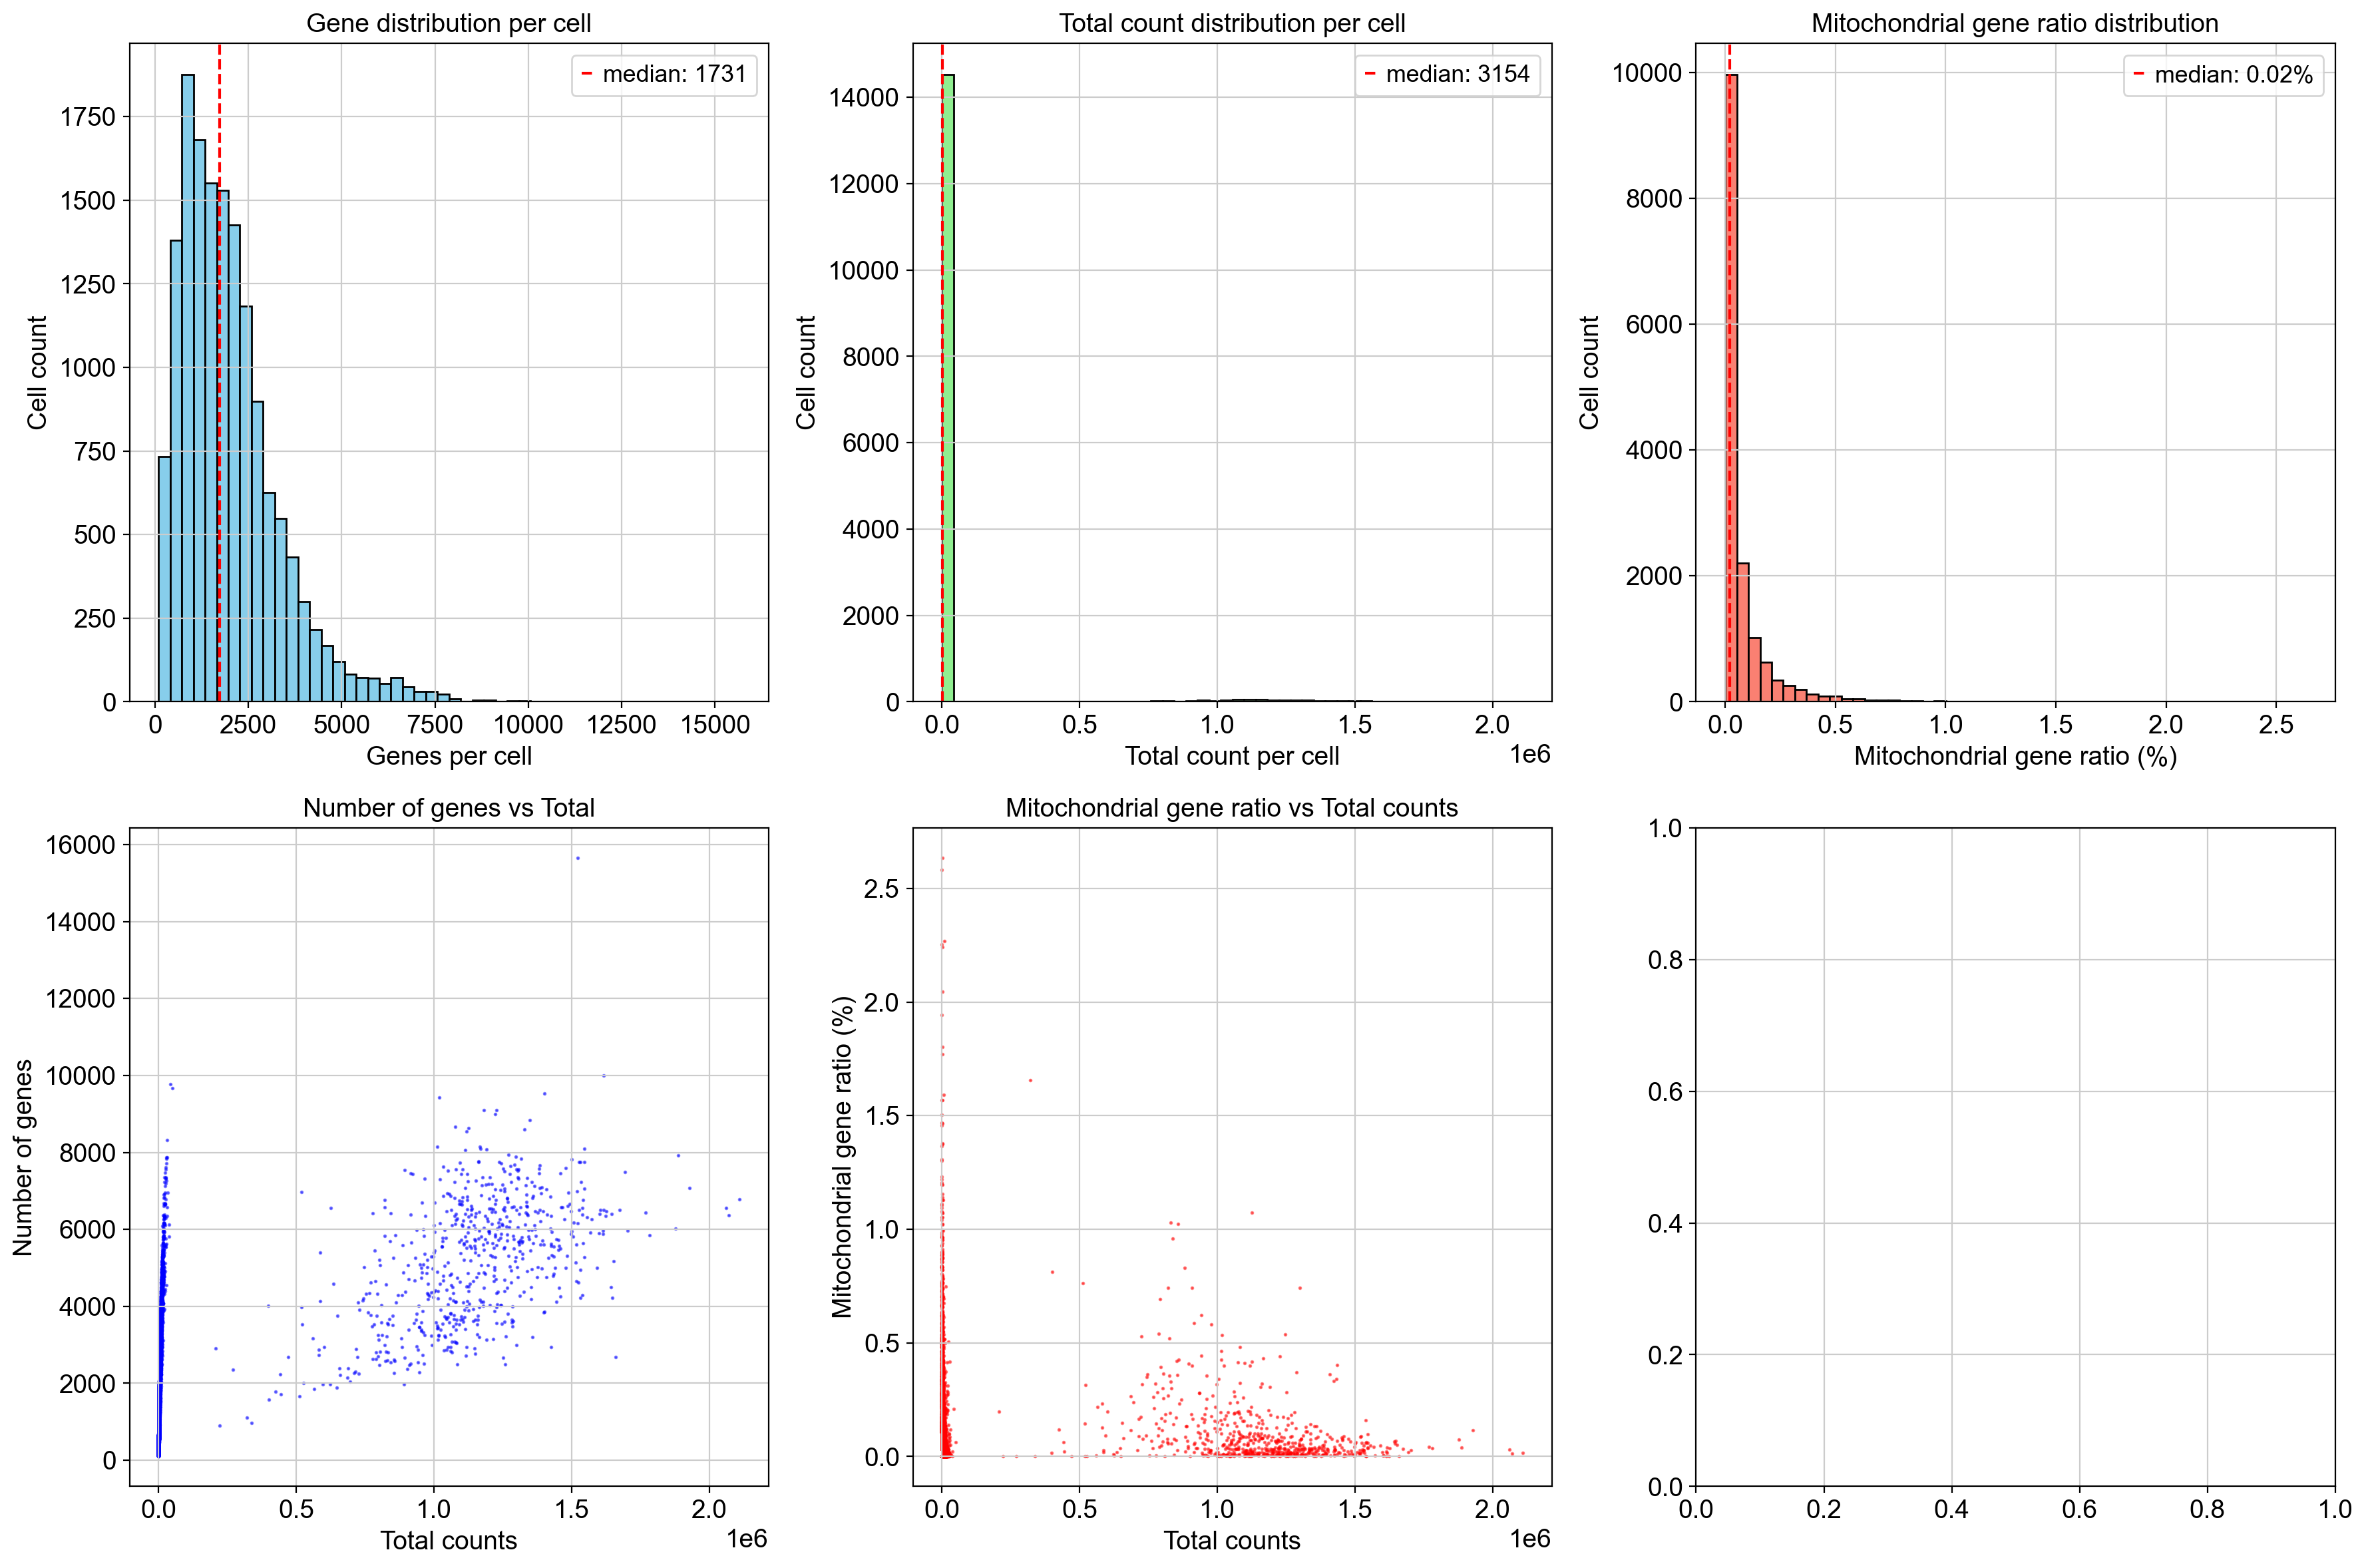


=== QC统计信息 ===
总细胞数: 15174
总基因数: 28692
每个细胞的基因数量 - 中位数: 1731
每个细胞的基因数量 - 平均值: 1981
每个细胞的总计数 - 中位数: 3154
每个细胞的总计数 - 平均值: 52194
线粒体基因比例 - 中位数: 0.02%
线粒体基因比例 - 平均值: 0.07%


In [7]:
# ==================== Cell 4: 生成QC图表函数 ====================
def plot_qc_metrics(adata, save_path=None):
    """生成质量控制图表"""
    print("生成质量控制图表...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. 每个细胞的基因数量分布
    axes[0,0].hist(adata.obs['n_genes_by_counts'], bins=50, color='skyblue', edgecolor='black')
    axes[0,0].axvline(adata.obs['n_genes_by_counts'].median(), color='red', linestyle='--', 
                     label=f'median: {adata.obs["n_genes_by_counts"].median():.0f}')
    axes[0,0].set_xlabel('Genes per cell')
    axes[0,0].set_ylabel('Cell count')
    axes[0,0].set_title('Gene distribution per cell')
    axes[0,0].legend()
    
    # 2. 每个细胞的总计数分布
    axes[0,1].hist(adata.obs['total_counts'], bins=50, color='lightgreen', edgecolor='black')
    axes[0,1].axvline(adata.obs['total_counts'].median(), color='red', linestyle='--',
                     label=f'median: {adata.obs["total_counts"].median():.0f}')
    axes[0,1].set_xlabel('Total count per cell')
    axes[0,1].set_ylabel('Cell count')
    axes[0,1].set_title('Total count distribution per cell')
    axes[0,1].legend()
    
    # 3. 线粒体基因比例分布
    if 'pct_counts_mt' in adata.obs.columns:
        axes[0,2].hist(adata.obs['pct_counts_mt'], bins=50, color='salmon', edgecolor='black')
        axes[0,2].axvline(adata.obs['pct_counts_mt'].median(), color='red', linestyle='--',
                         label=f'median: {adata.obs["pct_counts_mt"].median():.2f}%')
        axes[0,2].set_xlabel('Mitochondrial gene ratio (%)')
        axes[0,2].set_ylabel('Cell count')
        axes[0,2].set_title('Mitochondrial gene ratio distribution')
        axes[0,2].legend()
    
    # 4. 基因数量 vs 总计数（散点图）
    axes[1,0].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], 
                     alpha=0.5, s=1, color='blue')
    axes[1,0].set_xlabel('Total counts')
    axes[1,0].set_ylabel('Number of genes')
    axes[1,0].set_title('Number of genes vs Total')
    
    # 5. 线粒体基因比例 vs 总计数（散点图）
    if 'pct_counts_mt' in adata.obs.columns:
        axes[1,1].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], 
                         alpha=0.5, s=1, color='red')
        axes[1,1].set_xlabel('Total counts')
        axes[1,1].set_ylabel('Mitochondrial gene ratio (%)')
        axes[1,1].set_title('Mitochondrial gene ratio vs Total counts')
    
    # 6. 批次信息（按测序方法）
    if 'batch' in adata.obs.columns:
        batch_counts = adata.obs['batch'].value_counts()
        axes[1,2].bar(batch_counts.index, batch_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        axes[1,2].set_xlabel('Sequencing methods')
        axes[1,2].set_ylabel('Cell count')
        axes[1,2].set_title('Cell count of each batch')
        axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"QC图表已保存到: {save_path}")
    
    plt.show()
    
    # 打印QC统计信息
    print("\n=== QC统计信息 ===")
    print(f"总细胞数: {adata.n_obs}")
    print(f"总基因数: {adata.n_vars}")
    print(f"每个细胞的基因数量 - 中位数: {adata.obs['n_genes_by_counts'].median():.0f}")
    print(f"每个细胞的基因数量 - 平均值: {adata.obs['n_genes_by_counts'].mean():.0f}")
    print(f"每个细胞的总计数 - 中位数: {adata.obs['total_counts'].median():.0f}")
    print(f"每个细胞的总计数 - 平均值: {adata.obs['total_counts'].mean():.0f}")
    
    if 'pct_counts_mt' in adata.obs.columns:
        print(f"线粒体基因比例 - 中位数: {adata.obs['pct_counts_mt'].median():.2f}%")
        print(f"线粒体基因比例 - 平均值: {adata.obs['pct_counts_mt'].mean():.2f}%")

# 生成原始数据的QC图
plot_qc_metrics(adata_with_qc, 'results/GSE132044_QC_metrics_before_filtering.png')

生成 Barcode Rank Plot...
Barcode Rank Plot 已保存到: results/GSE132044_barcode_rank_before_filtering.png


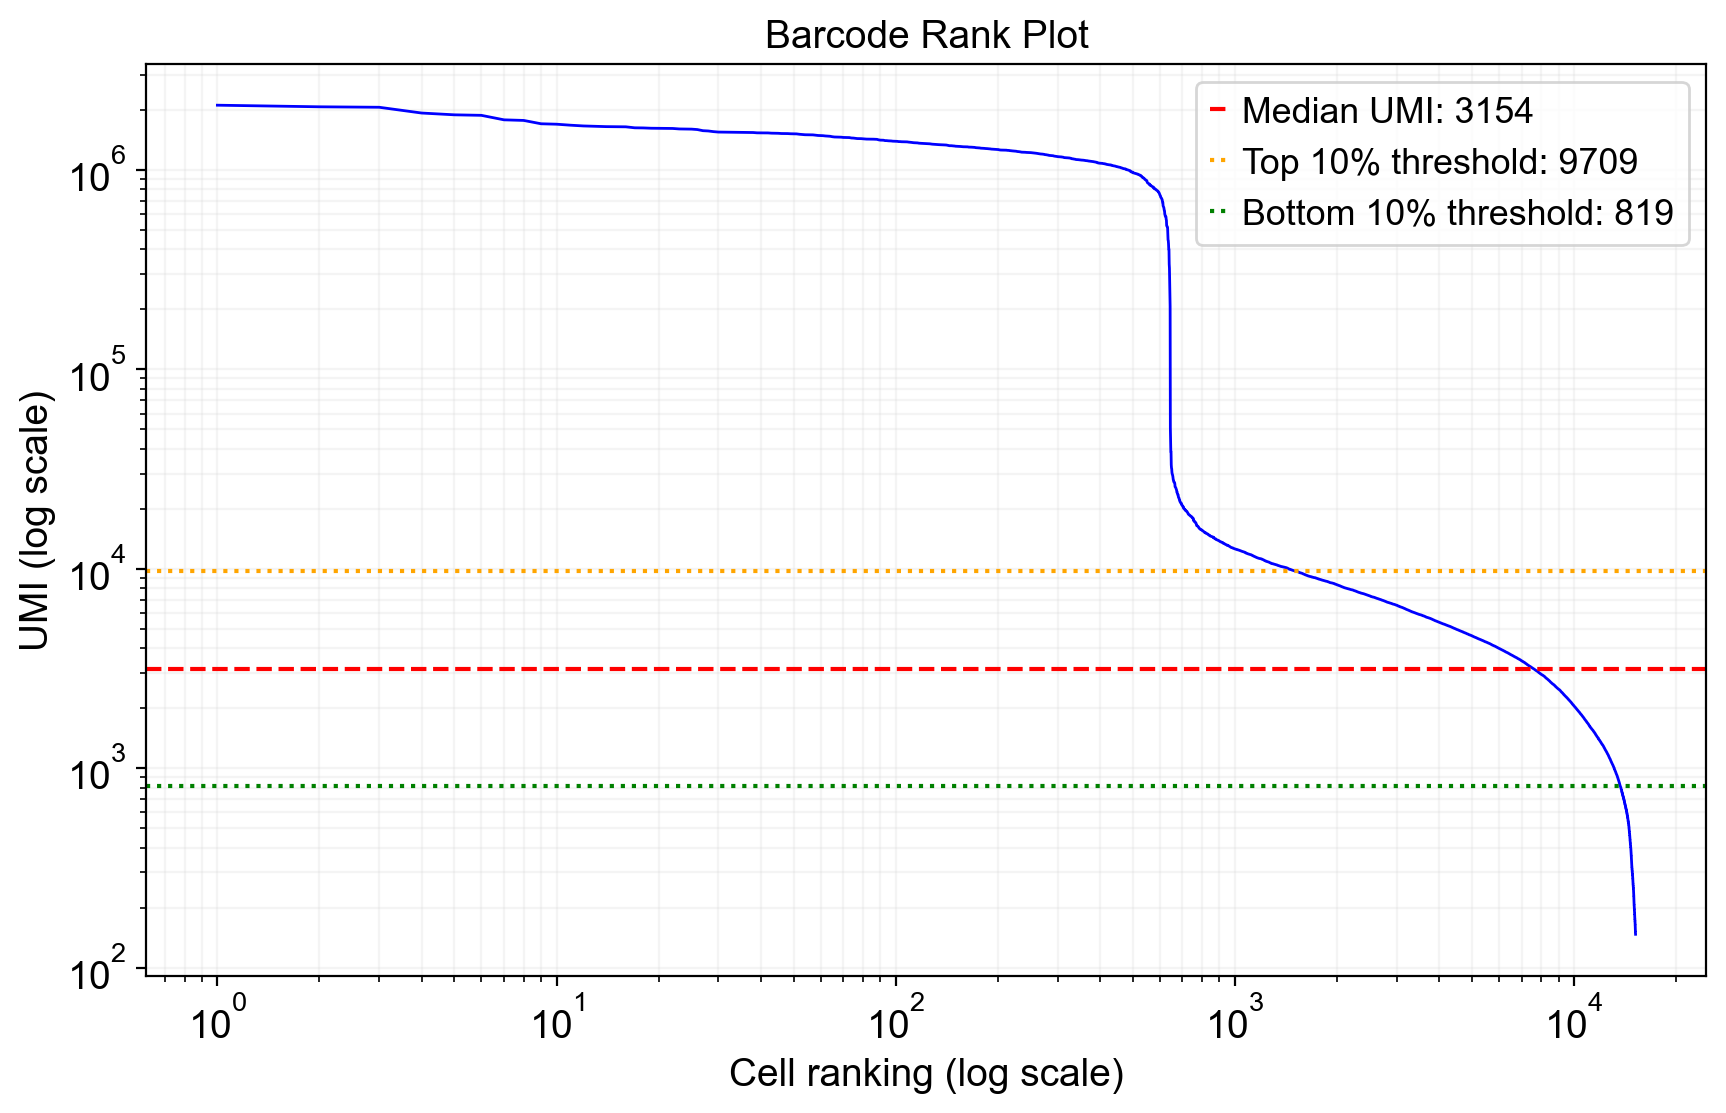


=== Barcode Rank 统计信息 ===
最大 UMI 计数: 2109448
最小 UMI 计数: 147
中位数 UMI 计数: 3154
前10%细胞的最小 UMI: 9709
前1%细胞的最小 UMI: 1312510


In [8]:
# ==================== Cell 5: 生成 Barcode Rank Plot ====================
def plot_barcode_rank(adata, save_path=None):
    """生成 Barcode Rank Plot"""
    print("生成 Barcode Rank Plot...")
    
    # 计算每个细胞的UMI计数（总计数）
    umi_counts = adata.obs['total_counts'].values
    
    # 按UMI计数降序排序
    sorted_umi = np.sort(umi_counts)[::-1]
    
    # 计算排名
    ranks = np.arange(1, len(sorted_umi) + 1)
    
    # 创建图表
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, sorted_umi, linewidth=1, color='blue')
    plt.xlabel('Cell ranking (log scale)')
    plt.ylabel('UMI (log scale)')
    plt.title('Barcode Rank Plot')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # 添加中位数线
    median_umi = np.median(sorted_umi)
    plt.axhline(y=median_umi, color='red', linestyle='--', 
                label=f'Median UMI: {median_umi:.0f}')
    
    # 标记典型阈值
    if len(sorted_umi) > 0:
        # 标记前10%的细胞
        top_10_threshold = sorted_umi[int(len(sorted_umi) * 0.1)]
        plt.axhline(y=top_10_threshold, color='orange', linestyle=':', 
                   label=f'Top 10% threshold: {top_10_threshold:.0f}')
        
        # 标记底部10%的细胞
        bottom_10_threshold = sorted_umi[int(len(sorted_umi) * 0.9)]
        plt.axhline(y=bottom_10_threshold, color='green', linestyle=':', 
                   label=f'Bottom 10% threshold: {bottom_10_threshold:.0f}')
    
    plt.legend()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Barcode Rank Plot 已保存到: {save_path}")
    
    plt.show()
    
    # 打印统计信息
    print("\n=== Barcode Rank 统计信息 ===")
    print(f"最大 UMI 计数: {sorted_umi[0]:.0f}")
    print(f"最小 UMI 计数: {sorted_umi[-1]:.0f}")
    print(f"中位数 UMI 计数: {median_umi:.0f}")
    print(f"前10%细胞的最小 UMI: {sorted_umi[int(len(sorted_umi) * 0.1)]:.0f}")
    print(f"前1%细胞的最小 UMI: {sorted_umi[int(len(sorted_umi) * 0.01)]:.0f}")

# 生成原始数据的Barcode Rank Plot
plot_barcode_rank(adata_with_qc, 'results/GSE132044_barcode_rank_before_filtering.png')

In [9]:
# ==================== Cell 6: 数据预处理 ====================
def preprocess_adata(adata):
    """数据预处理流程"""
    print("开始数据预处理...")
    
    # 复制原始数据
    adata_processed = adata.copy()
    
    # 设置批次信息
    adata_processed.obs['batch'] = adata_processed.obs['method']
    print(f"批次信息: {adata_processed.obs['batch'].value_counts()}")
    
    # 1. 基本QC指标（确保已经计算）
    print("1. 计算QC指标...")
    if 'n_genes_by_counts' not in adata_processed.obs.columns:
        # 标记线粒体基因
        gene_symbols = adata_processed.var_names.str.split('_').str[1]
        adata_processed.var['mt'] = gene_symbols.str.startswith('mt-')
        
        # 计算QC指标
        sc.pp.calculate_qc_metrics(
            adata_processed, 
            qc_vars=['mt'], 
            percent_top=None, 
            log1p=False, 
            inplace=True
        )
    
    # 2. 过滤细胞和基因
    print("2. 过滤低质量细胞和基因...")
    print(f"过滤前: {adata_processed.shape}")
    
    # 过滤低表达基因
    sc.pp.filter_genes(adata_processed, min_cells=3)
    
    # 过滤低质量细胞（基于基因数和线粒体比例）
    n_genes_threshold = 200
    mt_threshold = 20  # 线粒体基因比例阈值
    
    cell_filter = (adata_processed.obs['n_genes_by_counts'] >= n_genes_threshold) & \
                  (adata_processed.obs['pct_counts_mt'] <= mt_threshold)
    adata_processed = adata_processed[cell_filter, :]
    
    print(f"过滤后: {adata_processed.shape}")
    
    # 3. 标准化
    print("3. 数据标准化...")
    sc.pp.normalize_total(adata_processed, target_sum=1e4)
    sc.pp.log1p(adata_processed)
    
    # 4. 识别高变基因
    print("4. 识别高变基因...")
    sc.pp.highly_variable_genes(adata_processed, n_top_genes=2000)
    adata_processed.raw = adata_processed  # 保存原始数据
    
    # 使用高变基因
    adata_processed = adata_processed[:, adata_processed.var.highly_variable]
    
    # 5. 缩放和PCA
    print("5. 缩放数据和PCA...")
    sc.pp.scale(adata_processed, max_value=10)
    sc.tl.pca(adata_processed, svd_solver='arpack')
    
    print("数据预处理完成!")
    return adata_processed

# 执行预处理
adata_processed = preprocess_adata(adata_with_qc)

开始数据预处理...
批次信息: batch
sci-RNA-seq        5830
10x-Chromium-v2    5571
DroNc-seq          3130
Smart-seq2          643
Name: count, dtype: int64
1. 计算QC指标...
2. 过滤低质量细胞和基因...
过滤前: (15174, 28692)
过滤后: (14931, 24735)
3. 数据标准化...
4. 识别高变基因...
5. 缩放数据和PCA...
数据预处理完成!


生成过滤前后的QC对比图...
QC对比图已保存到: results/GSE132044_QC_comparison.png


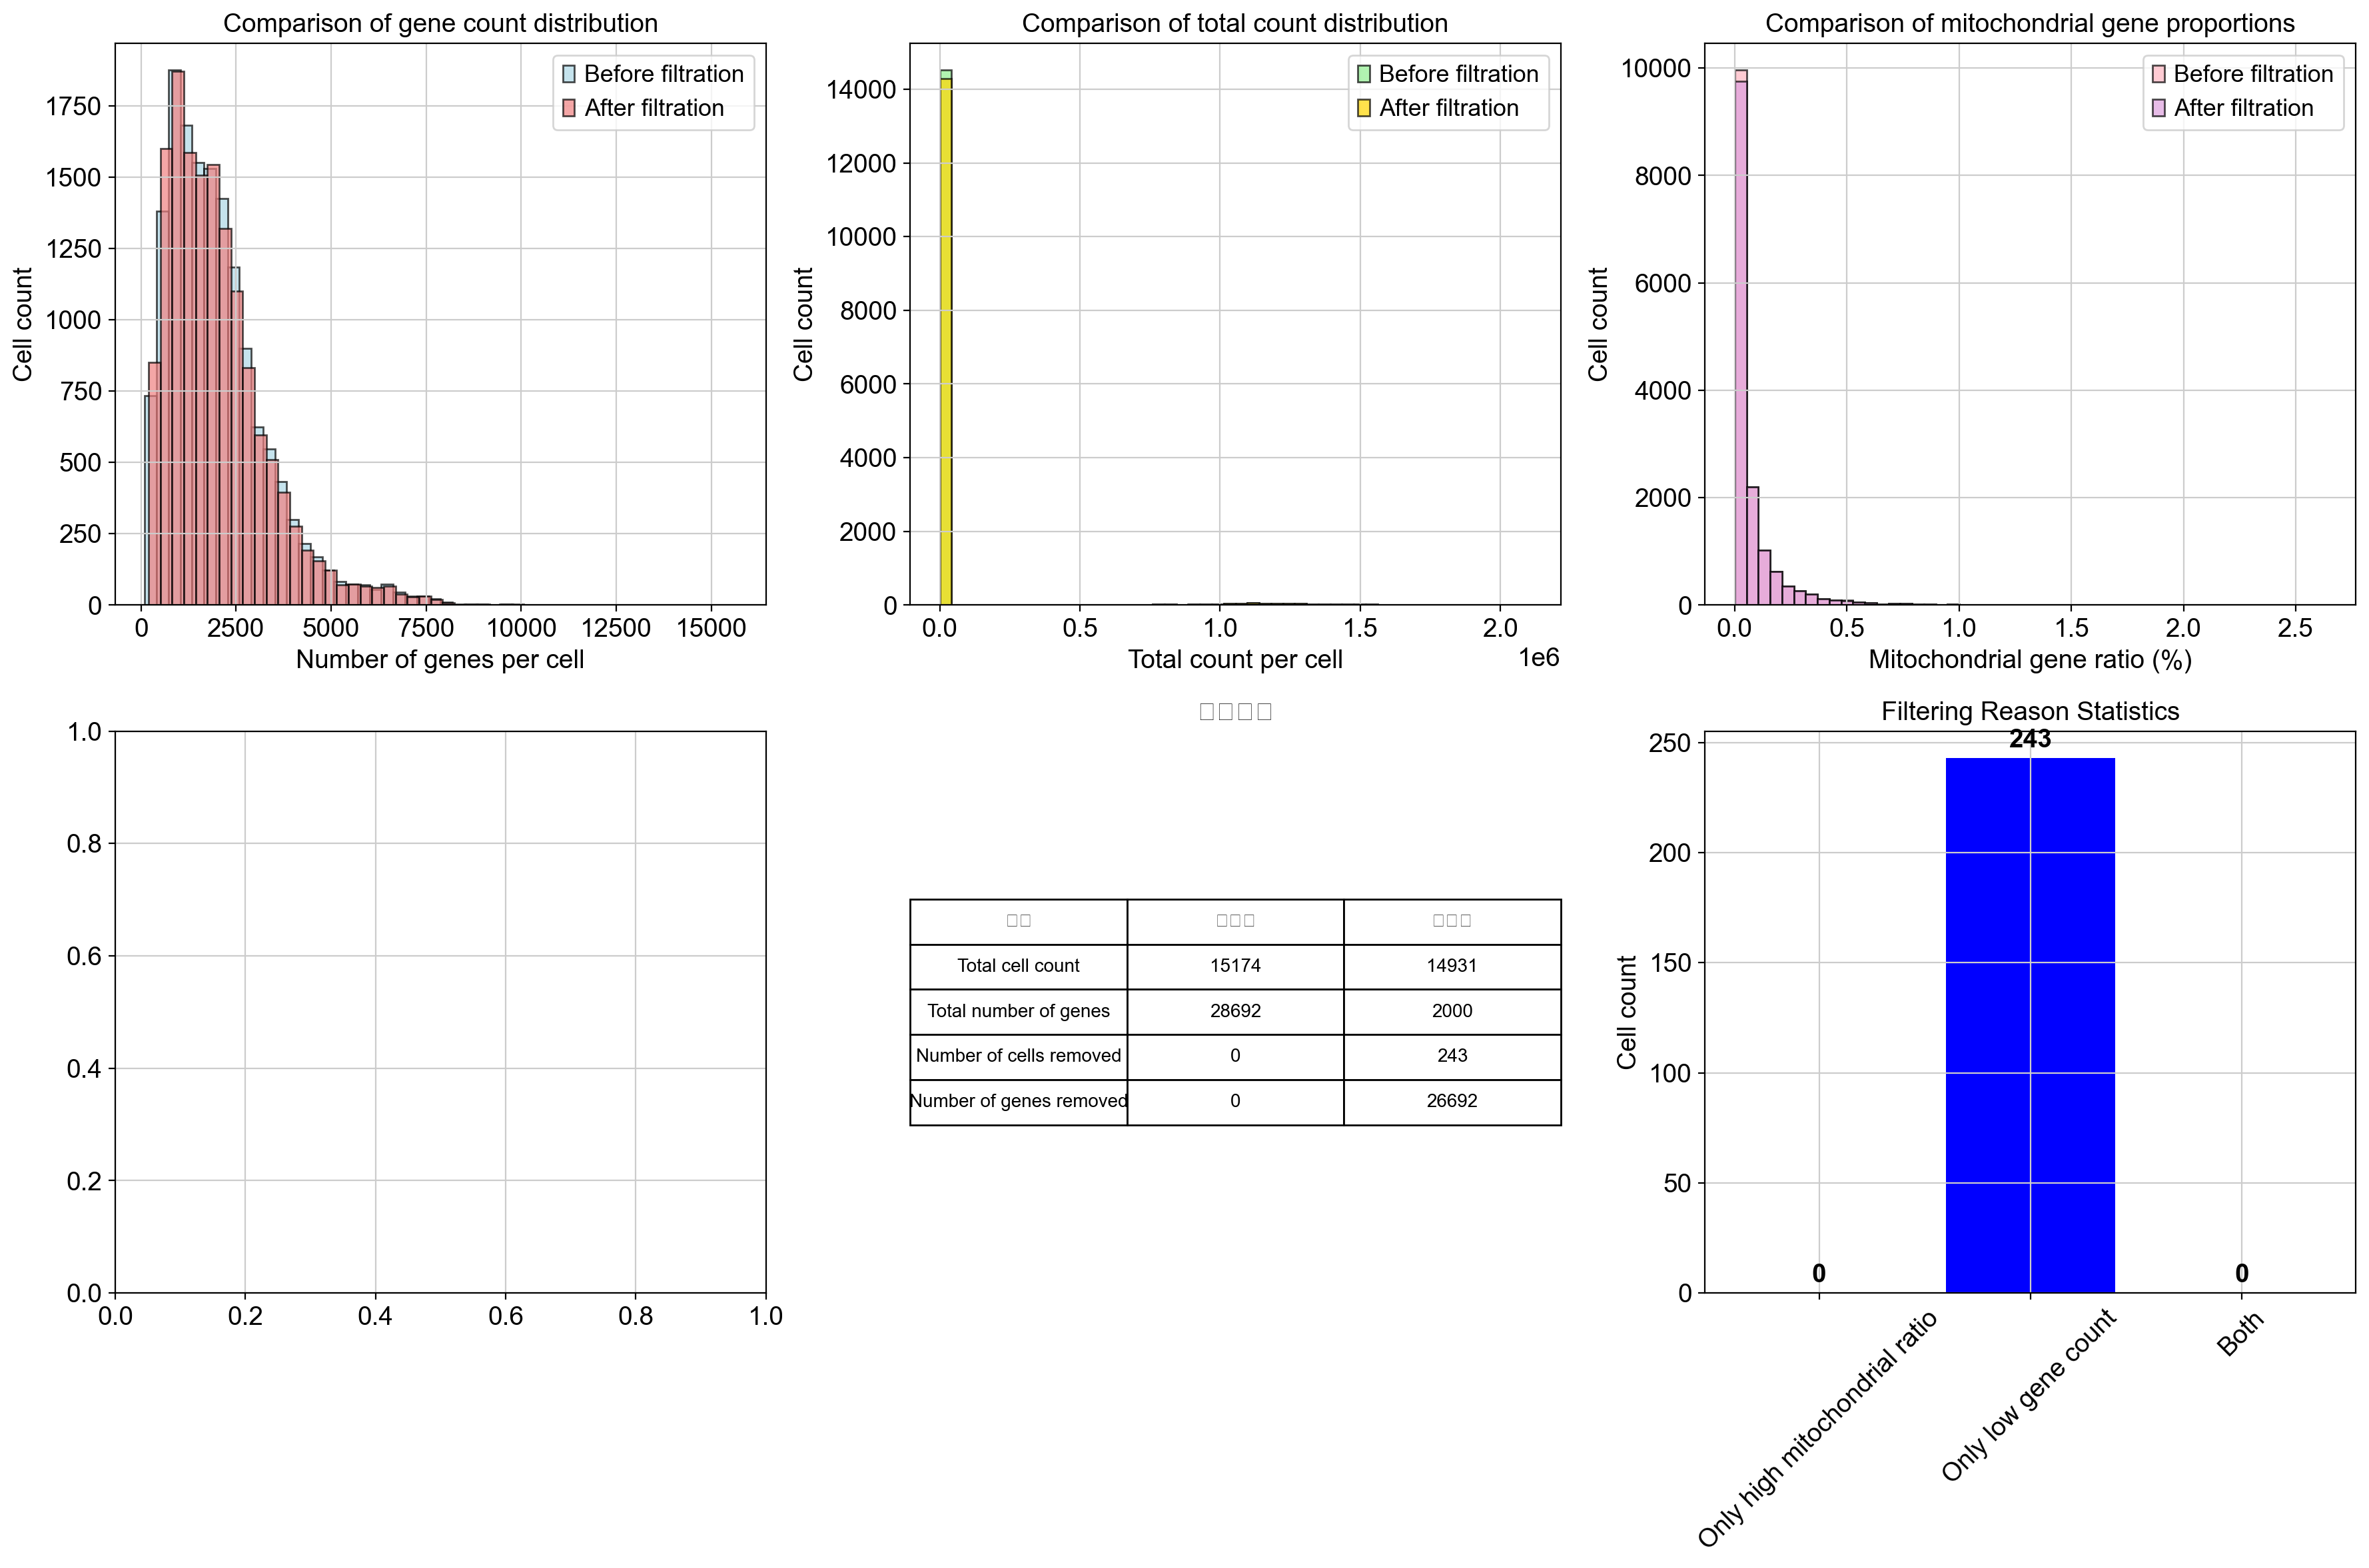


=== 过滤前后详细统计 ===
过滤前细胞数: 15174
过滤后细胞数: 14931
移除细胞数: 243 (1.60%)
过滤前基因数: 28692
过滤后基因数: 2000
移除基因数: 26692 (93.03%)

=== 过滤原因分析 ===
因高线粒体比例移除: 0 细胞
因低基因数量移除: 243 细胞
因两者都差移除: 0 细胞
生成 Barcode Rank Plot...
Barcode Rank Plot 已保存到: results/GSE132044_barcode_rank_after_filtering.png


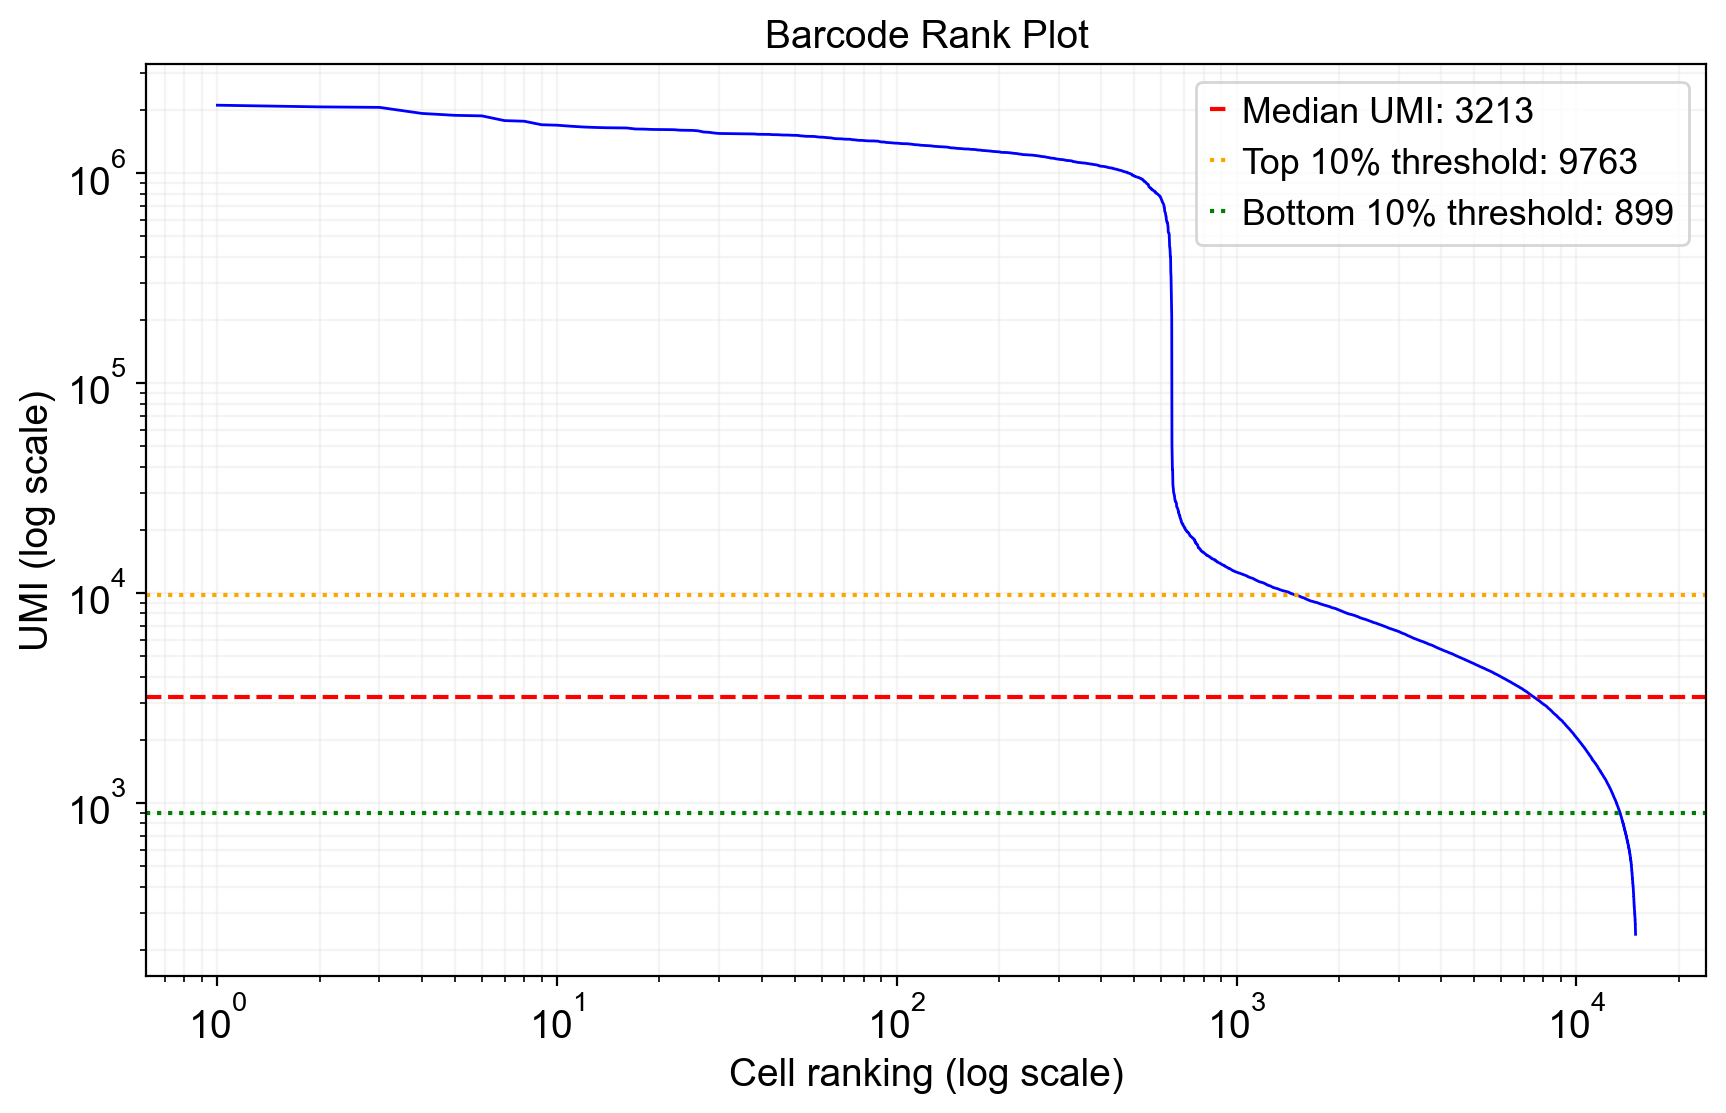


=== Barcode Rank 统计信息 ===
最大 UMI 计数: 2109448
最小 UMI 计数: 237
中位数 UMI 计数: 3213
前10%细胞的最小 UMI: 9763
前1%细胞的最小 UMI: 1313877


In [11]:
# ==================== Cell 7: 生成过滤前后的QC对比图 ====================
def plot_qc_comparison(adata_before, adata_after, save_path=None):
    """生成过滤前后的QC对比图"""
    print("生成过滤前后的QC对比图...")
    
    # 确保adata_before有QC指标
    if 'n_genes_by_counts' not in adata_before.obs.columns:
        print("原始数据缺少QC指标，跳过对比图")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. 基因数量分布对比
    axes[0,0].hist(adata_before.obs['n_genes_by_counts'], bins=50, alpha=0.7, 
                  label='Before filtration', color='lightblue', edgecolor='black')
    axes[0,0].hist(adata_after.obs['n_genes_by_counts'], bins=50, alpha=0.7, 
                  label='After filtration', color='lightcoral', edgecolor='black')
    axes[0,0].set_xlabel('Number of genes per cell')
    axes[0,0].set_ylabel('Cell count')
    axes[0,0].set_title('Comparison of gene count distribution')
    axes[0,0].legend()
    
    # 2. 总计数分布对比
    axes[0,1].hist(adata_before.obs['total_counts'], bins=50, alpha=0.7, 
                  label='Before filtration', color='lightgreen', edgecolor='black')
    axes[0,1].hist(adata_after.obs['total_counts'], bins=50, alpha=0.7, 
                  label='After filtration', color='gold', edgecolor='black')
    axes[0,1].set_xlabel('Total count per cell')
    axes[0,1].set_ylabel('Cell count')
    axes[0,1].set_title('Comparison of total count distribution')
    axes[0,1].legend()
    
    # 3. 线粒体基因比例分布对比
    if 'pct_counts_mt' in adata_before.obs.columns and 'pct_counts_mt' in adata_after.obs.columns:
        axes[0,2].hist(adata_before.obs['pct_counts_mt'], bins=50, alpha=0.7, 
                      label='Before filtration', color='lightpink', edgecolor='black')
        axes[0,2].hist(adata_after.obs['pct_counts_mt'], bins=50, alpha=0.7, 
                      label='After filtration', color='plum', edgecolor='black')
        axes[0,2].set_xlabel('Mitochondrial gene ratio (%)')
        axes[0,2].set_ylabel('Cell count')
        axes[0,2].set_title('Comparison of mitochondrial gene proportions')
        axes[0,2].legend()
    
    # 4. 批次分布对比
    if 'batch' in adata_before.obs.columns:
        before_batch = adata_before.obs['batch'].value_counts()
        after_batch = adata_after.obs['batch'].value_counts()
        
        x = np.arange(len(before_batch))
        width = 0.35
        
        axes[1,0].bar(x - width/2, before_batch.values, width, label='Before filtration', color='lightblue')
        axes[1,0].bar(x + width/2, after_batch.values, width, label='After filtration', color='lightcoral')
        axes[1,0].set_xlabel('Sequencing methods')
        axes[1,0].set_ylabel('Cell count')
        axes[1,0].set_title('Comparison of cell counts in different batches')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(before_batch.index, rotation=45)
        axes[1,0].legend()
    
    # 5. 过滤统计
    cells_removed = adata_before.n_obs - adata_after.n_obs
    genes_removed = adata_before.n_vars - adata_after.n_vars
    
    stats_data = {
        '指标': ['Total cell count', 'Total number of genes', 'Number of cells removed', 'Number of genes removed'],
        '过滤前': [adata_before.n_obs, adata_before.n_vars, 0, 0],
        '过滤后': [adata_after.n_obs, adata_after.n_vars, cells_removed, genes_removed]
    }
    
    stats_df = pd.DataFrame(stats_data)
    axes[1,1].axis('off')
    table = axes[1,1].table(cellText=stats_df.values, 
                           colLabels=stats_df.columns, 
                           cellLoc='center', 
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[1,1].set_title('过滤统计')
    
    # 6. 过滤原因分析
    if 'pct_counts_mt' in adata_before.obs.columns:
        mt_threshold = 20
        gene_threshold = 200
        
        # 计算各种过滤原因
        mt_high_only = ((adata_before.obs['pct_counts_mt'] > mt_threshold) & 
                       (adata_before.obs['n_genes_by_counts'] >= gene_threshold)).sum()
        
        genes_low_only = ((adata_before.obs['pct_counts_mt'] <= mt_threshold) & 
                         (adata_before.obs['n_genes_by_counts'] < gene_threshold)).sum()
        
        both_bad = ((adata_before.obs['pct_counts_mt'] > mt_threshold) & 
                   (adata_before.obs['n_genes_by_counts'] < gene_threshold)).sum()
        
        reasons = ['Only high mitochondrial ratio', 'Only low gene count', 'Both']
        counts = [mt_high_only, genes_low_only, both_bad]
        
        axes[1,2].bar(reasons, counts, color=['red', 'blue', 'purple'])
        axes[1,2].set_ylabel('Cell count')
        axes[1,2].set_title('Filtering Reason Statistics')
        axes[1,2].tick_params(axis='x', rotation=45)
        
        # 在柱状图上添加数值标签
        for i, count in enumerate(counts):
            axes[1,2].text(i, count + max(counts)*0.01, str(count), 
                          ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"QC对比图已保存到: {save_path}")
    
    plt.show()
    
    # 打印详细统计
    print("\n=== 过滤前后详细统计 ===")
    print(f"过滤前细胞数: {adata_before.n_obs}")
    print(f"过滤后细胞数: {adata_after.n_obs}")
    print(f"移除细胞数: {cells_removed} ({cells_removed/adata_before.n_obs*100:.2f}%)")
    print(f"过滤前基因数: {adata_before.n_vars}")
    print(f"过滤后基因数: {adata_after.n_vars}")
    print(f"移除基因数: {genes_removed} ({genes_removed/adata_before.n_vars*100:.2f}%)")
    
    if 'pct_counts_mt' in adata_before.obs.columns:
        print(f"\n=== 过滤原因分析 ===")
        print(f"因高线粒体比例移除: {mt_high_only} 细胞")
        print(f"因低基因数量移除: {genes_low_only} 细胞")
        print(f"因两者都差移除: {both_bad} 细胞")

# 生成过滤前后的QC对比图
plot_qc_comparison(adata_with_qc, adata_processed, 'results/GSE132044_QC_comparison.png')

# 生成过滤后的Barcode Rank Plot
plot_barcode_rank(adata_processed, 'results/GSE132044_barcode_rank_after_filtering.png')

生成高变基因分析图...
高变基因分析图已保存到: results/GSE132044_HVG_analysis.png


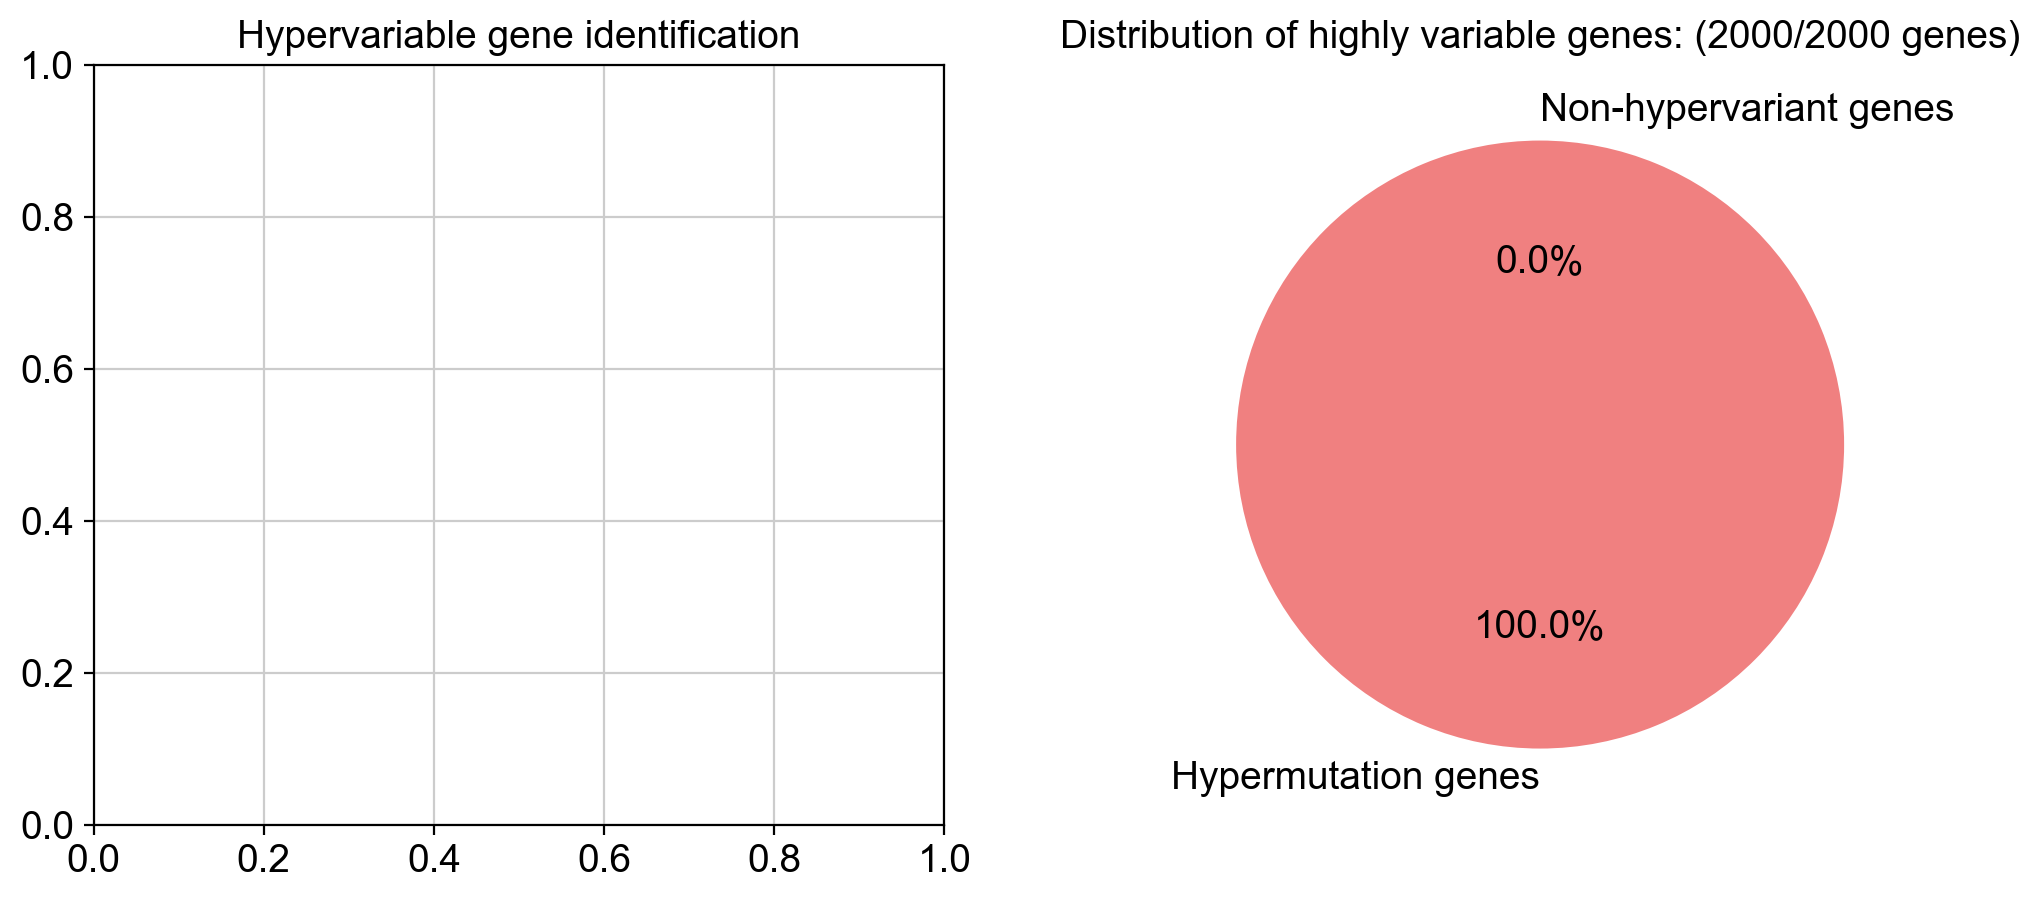

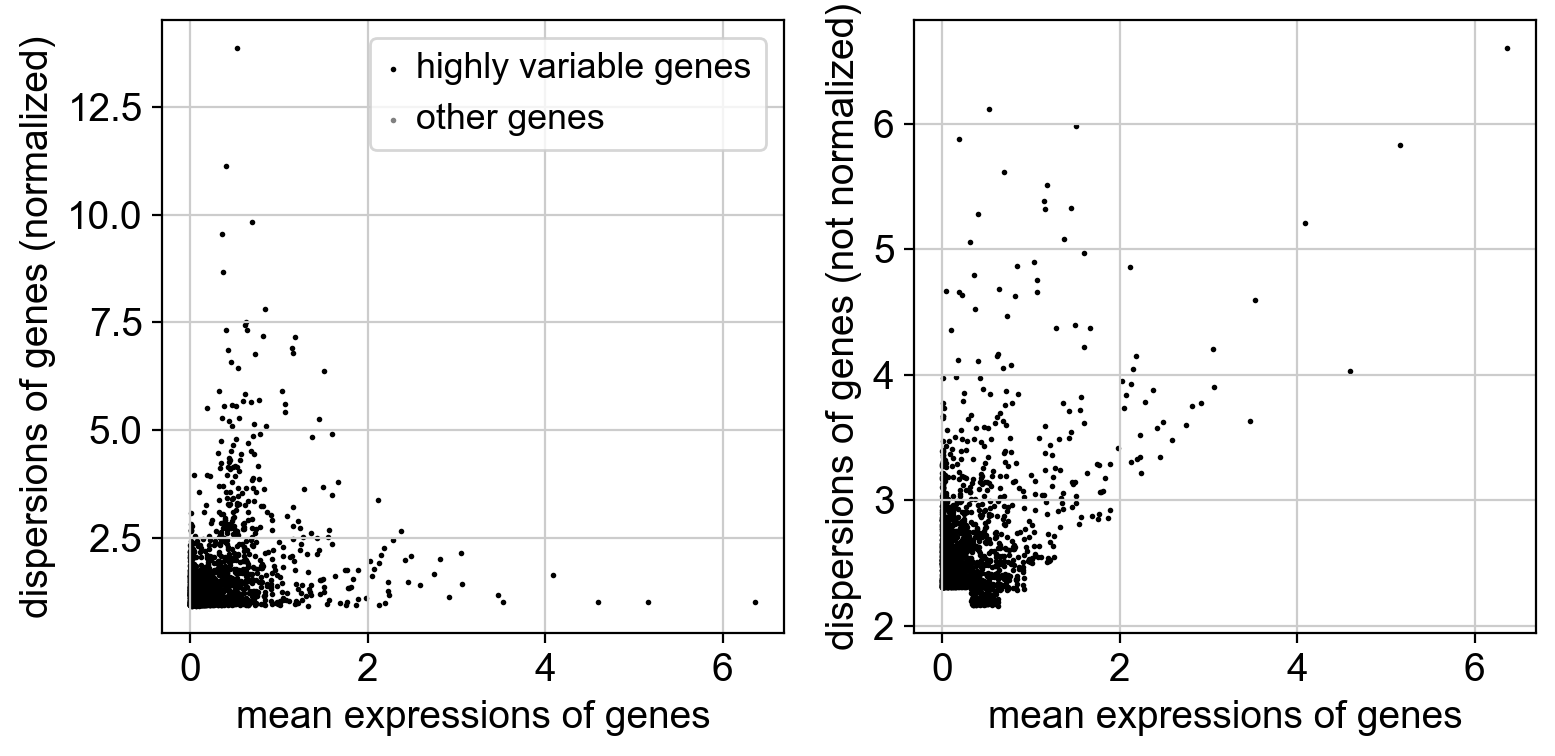


=== 高变基因统计 ===
总基因数: 2000
高变基因数: 2000
高变基因比例: 100.00%


In [13]:
# ==================== Cell 8: 生成高变基因分析图 ====================
def plot_hvg_analysis(adata, save_path=None):
    """生成高变基因分析图"""
    print("生成高变基因分析图...")
    
    if 'highly_variable' not in adata.var.columns:
        print("未找到高变基因信息，跳过此图")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1. 高变基因识别图
    sc.pl.highly_variable_genes(adata, show=False)
    axes[0].set_title('Hypervariable gene identification')
    
    # 2. 高变基因统计
    hvg_count = adata.var['highly_variable'].sum()
    total_genes = len(adata.var)
    
    labels = ['Hypermutation genes', 'Non-hypervariant genes']
    sizes = [hvg_count, total_genes - hvg_count]
    colors = ['lightcoral', 'lightblue']
    
    axes[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f'Distribution of highly variable genes: ({hvg_count}/{total_genes} genes)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"高变基因分析图已保存到: {save_path}")
    
    plt.show()
    
    print(f"\n=== 高变基因统计 ===")
    print(f"总基因数: {total_genes}")
    print(f"高变基因数: {hvg_count}")
    print(f"高变基因比例: {hvg_count/total_genes*100:.2f}%")

# 生成高变基因分析图
plot_hvg_analysis(adata_processed, 'results/GSE132044_HVG_analysis.png')